<a href="https://colab.research.google.com/github/yooshin2/Deep-Learning/blob/main/CIFAR_10_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment4. CIFAR-10 Classification with CNN

Lab7에서는 assignment3-CIFAR-10 Classification with MLP 코드의 MLP로 정의된 model arcitecture 부분을 수정하여 CNN으로 바꾸고, 이를 통해 CIFAR-10 dataset의 10-way classification을 CNN을 통해 해보았습니다. 그 과정에서 MLP에서 그러했듯, 다양한 hyperparameter들을 변수화하여 CNN model을 customize할 수 있게하였고, 그 결과 hyperparameter tunning 없이도 test accuracy 73%를 얻어낼 수 있었습니다. 그러나 loss graph 상에서 train / validation loss가 벌어지는 overfitting 현상 또한 볼 수 있었습니다.

본 과제에서는 kernel size등 더 다양한 hyperparamteter들을 변수화하여 control할 수 있게하고, l2 regularization, fully connected layer의 dropout 등 다양한 tecnique들을 적용해 CNN 모델의 성능을 더 높여보도록 합시다.


### 실험을 완료하신 뒤에는
주피터 노트북 파일의 끝 부분에 최종적으로 최적화한 hyperparameter set과 그에 따른 test/validation/train accuracy를 리포트해 주신 뒤 github 링크를 [과제 제출 및 피드백 링크](https://goo.gl/forms/LpHtAMinhIYiiKCY2) 를 통해 제출해주시면 감사하겠습니다.

<hr>  

# 시작하기

[제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec5/Assignment4_CIFAR-10_with_CNN.ipynb)를 통해 Colab에서 바로 작업하실 수 있습니다!  
만약 코드가 알록달록 하지 않다면(Syntax Highlighting이 안 된다면)  
그냥 새로운 python3, GPU 런타임으로 Colab 파일을 만드신 후 코드를 복붙하시는게 빠를 겁니다.   

<hr>

아래 코드를 통해 Colab에 연결되어 있는 서버 컴퓨터 내에 결과들을 저장할 results 폴더를 만들어봅시다.  
만약 이미 만들었다면 **File exists** 와 같은 에러가 뜨면서 새로운 폴더 생성이 불가능할텐데 폴더만 있다면 괜찮으니 넘어가줍시다.  

In [56]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

## Data Preparation

In [58]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [59]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [60]:
class CNN(nn.Module):
    
    def __init__(self, model_code, in_channels, hid_dim, use_bn):
        super(CNN, self).__init__()
        
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        self.classifier = nn.Sequential(nn.Linear(512, hid_dim),
                                        nn.ReLU(),
                                        nn.Linear(hid_dim, 10))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, model_code, in_channels, use_bn):
        layers = nn.ModuleList()
        for x in cfg[model_code]:
            if x != 'M':
                layers.append(nn.Conv2d(in_channels=in_channels,
                                        out_channels=x,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1))
                if use_bn:
                    layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU())
                in_channels = x
            else:
                layers.append(nn.MaxPool2d(kernel_size=2,
                                           stride=2))
        return layers

## Train, Validate, Test and Experiment

In [61]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [62]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [63]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [64]:
def experiment(partition, args):
  
    net = CNN(args.model_code, args.in_channels, args.hid_dim, args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment Result

In [65]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Visualization Utility

In [66]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

## Experiment


In [68]:
# ====== Random Seed Initialization ====== #
seed = 317
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_modelcode_optim"

# ====== Additional Entities ====== #
args.model_code = 'VGG19'
args.in_channels = 3
args.hid_dim = 256
args.use_bn = True

# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'optim'
list_var1 = ['VGG11', 'VGG13', 'VGG16', 'VGG19']
list_var2 = ['RMSprop', 'Adam']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=10, exp_name='exp1_modelcode_optim', hid_dim=256, in_channels=3, l2=1e-05, lr=0.0015, model_code='VGG11', optim='RMSprop', test_batch_size=1024, train_batch_size=256, use_bn=True)
Epoch 0, Acc(train/val): 18.19/25.37, Loss(train/val) 2.20/1.92. Took 14.45 sec
Epoch 1, Acc(train/val): 36.51/33.10, Loss(train/val) 1.64/1.89. Took 14.54 sec
Epoch 2, Acc(train/val): 51.83/41.89, Loss(train/val) 1.30/1.81. Took 14.82 sec
Epoch 3, Acc(train/val): 61.85/39.82, Loss(train/val) 1.05/2.12. Took 14.63 sec
Epoch 4, Acc(train/val): 69.71/55.11, Loss(train/val) 0.86/1.40. Took 14.44 sec
Epoch 5, Acc(train/val): 75.01/52.72, Loss(train/val) 0.72/1.69. Took 14.37 sec
Epoch 6, Acc(train/val): 78.86/52.02, Loss(train/val) 0.61/1.76. Took 14.24 sec
Epoch 7, Acc(train/val): 82.14/52.30, Loss(train/val) 0.52/1.78. Took 14.61 sec
Epoch 8, Acc(train/val): 84.86/72.39, Loss(train/val) 0.44/0.84. Took 14.66 sec
Epoch 9, Acc(train/val): 87.30/70.63, Loss(train/val) 0.37/1.02. Took 14

## experiment1을 통하여 optim을 Adam으로 결정.
## model_code experiment는 아직 뚜렷한 결과를 도출하지 못함.
## experiment2에서는 epoch값을 더 크게 설정하여 실험하고 lr와 hid_dim을 변경하며 실험하기로함.



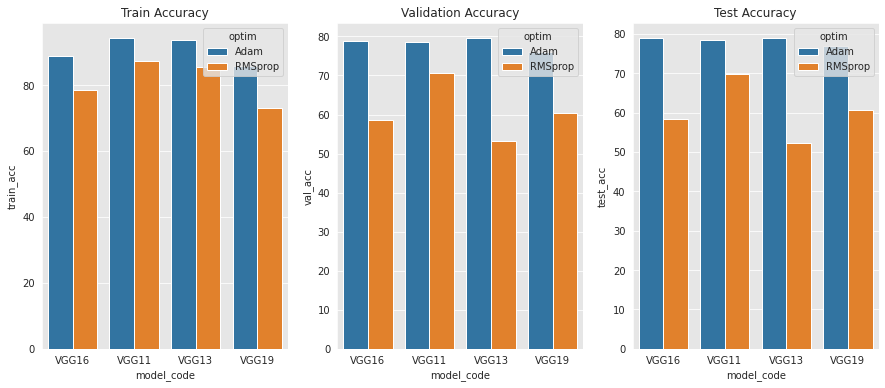

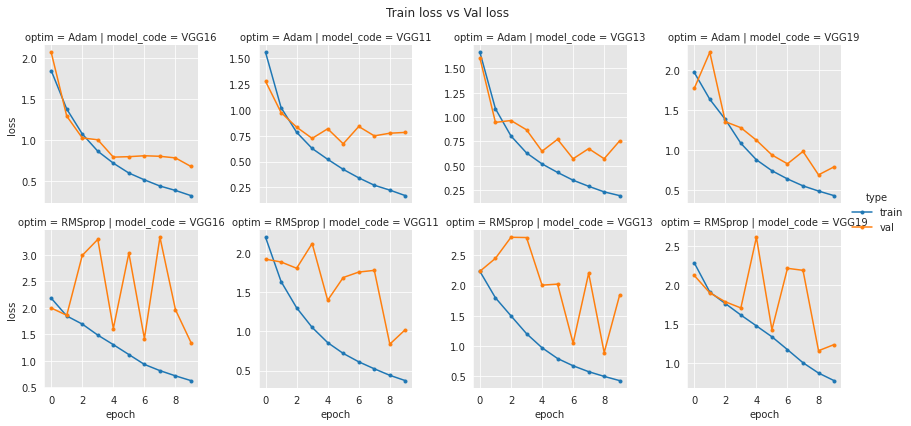

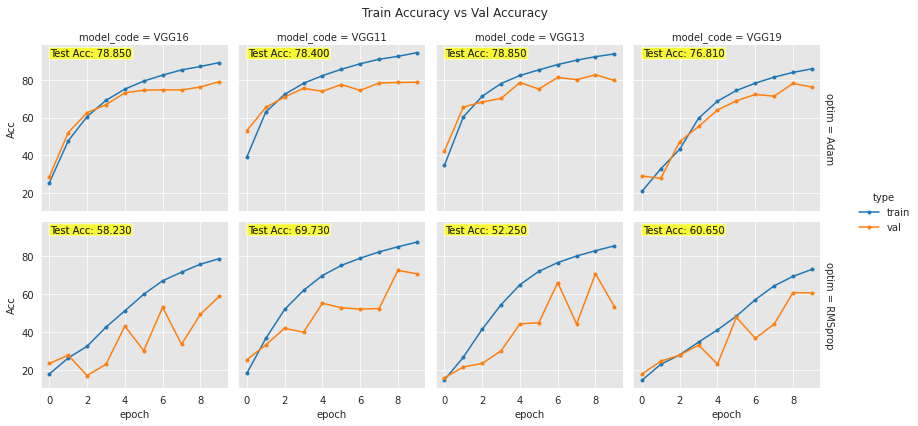

In [79]:
var1 = 'model_code'
var2 = 'optim'
df = load_exp_result('exp1_modelcode_optim')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모든 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [83]:
# ====== Random Seed Initialization ====== #
seed = 317
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_hid_dim"

# ====== Additional Entities ====== #
args.model_code = 'VGG16'
args.in_channels = 3
args.hid_dim = 256
args.use_bn = True

# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 25

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'hid_dim'
list_var1 = [0.0005, 0.001, 0.0015]
list_var2 = [256, 512]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=25, exp_name='exp2_lr_hid_dim', hid_dim=256, in_channels=3, l2=1e-05, lr=0.0005, model_code='VGG16', optim='Adam', test_batch_size=1024, train_batch_size=256, use_bn=True)
Epoch 0, Acc(train/val): 45.69/54.40, Loss(train/val) 1.43/1.28. Took 25.28 sec
Epoch 1, Acc(train/val): 66.47/64.98, Loss(train/val) 0.93/1.08. Took 24.96 sec
Epoch 2, Acc(train/val): 74.96/67.10, Loss(train/val) 0.72/1.05. Took 24.77 sec
Epoch 3, Acc(train/val): 80.29/73.86, Loss(train/val) 0.57/0.80. Took 24.85 sec
Epoch 4, Acc(train/val): 84.27/77.55, Loss(train/val) 0.46/0.70. Took 24.90 sec
Epoch 5, Acc(train/val): 87.05/77.99, Loss(train/val) 0.38/0.68. Took 24.98 sec
Epoch 6, Acc(train/val): 89.78/80.35, Loss(train/val) 0.31/0.64. Took 25.05 sec
Epoch 7, Acc(train/val): 91.45/74.65, Loss(train/val) 0.25/0.93. Took 24.83 sec
Epoch 8, Acc(train/val): 93.17/79.68, Loss(train/val) 0.20/0.71. Took 24.93 sec
Epoch 9, Acc(train/val): 94.73/80.63, Loss(train/val) 0.16/0.73. Took 24.76 sec


## epoch 값을 더 크게 설정하니 많은 시간이 소요됨.
## experiment를 하는 일이 시간이 많이 소요되는 과정이라는 것을 느낌.
## model_code experiment도 진행하려고 했으나 시간이 너무 걸려 포기함. (model_code='VGG16'로 고정)

## optim=Adam, lr=0.0015, hid_dim=512 에서 가장 좋은 결과 도출.


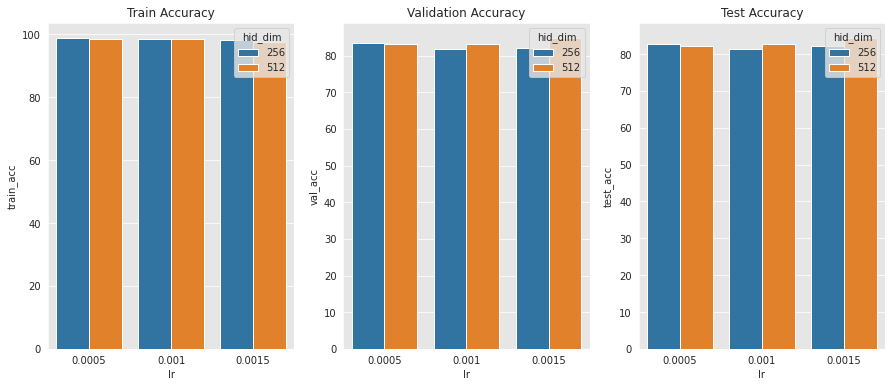

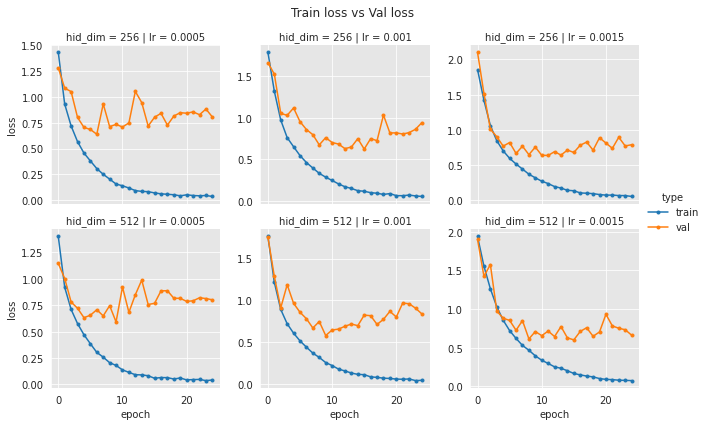

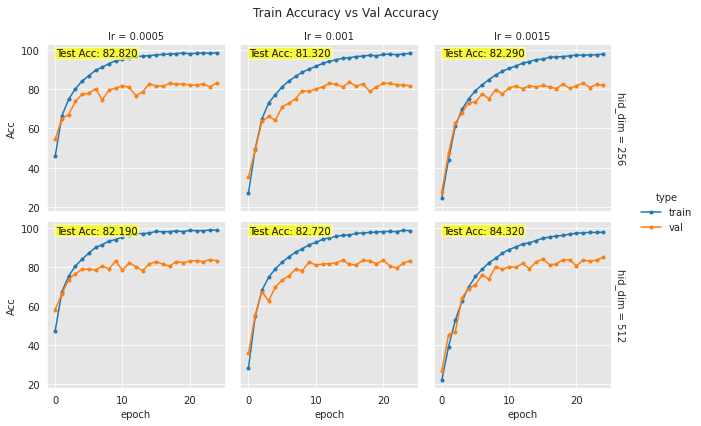

In [85]:
var1 = 'lr'
var2 = 'hid_dim'
df = load_exp_result('exp2_lr_hid_dim')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모든 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.